# INCOME Fastshap vs FastShap with DP

In [1]:
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch
import dill
# import from parent level
import sys
import copy

sys.path.append("../")
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
from fastshap import Surrogate, KLDivLoss
from scipy.stats import spearmanr
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
import torch.nn.functional as F
from fastshap import Surrogate, KLDivLoss
from aix360.metrics.local_metrics import faithfulness_metric
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import sys

sys.path.append("../")
from Utils.utils import Utils
from Client.client_explainer import prepare_dataset_for_explainer_FL

from metrics import agreement_fraction, pairwise_rank_agreement, rankcorr

import os
import torch
import torch.nn as nn
from fastshap.surrogate_dp import SurrogateDP

import sys

sys.path.append("../")
from pathlib import Path
from fastshap.fastshap_dp import (
    FastSHAP,
    calculate_grand_coalition_FL,
    validate_FL,
)

import warnings

# ignore warnings
warnings.filterwarnings("ignore")

/home/lcorbucci/private_fastshap/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-29 18:10:27,962	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Functions

In [2]:
def prepare_data_FL(
    test_clients,
    batch_size,
    dataset_name,
    num_workers,
    fed_dir,
    device,
    num_features,
    surrogate,
    seed=42,
):
    samples, targets = [], []
    for client in test_clients:
        data = Utils.get_dataset(
            path_to_data=Path(fed_dir),
            cid=client,
            dataset=dataset_name,
            partition="train",
        )
        for item in data:
            X, _, y = item
            samples.append(X)
            targets.append(y)

    return samples, targets

In [3]:
# Faithfulness evaluation
class aix_model:
    def __init__(self, model):
        self.model = model

    def predict(self, x):
        x = torch.Tensor(x)
        return self.model(x).argmax(dim=1)

    def predict_proba(self, x):
        # since the activation function of the last layer is LogSoftmax
        # we need to apply the exponential to the output of the model
        # cast x to be a Tensor
        x = torch.Tensor(x)
        return torch.functional.softmax(self.model(x)).detach().numpy()


def compute_faithfulness(x, y, fastshap_explanation, model, base_value):
    x = x[0]
    fastshap_explanation = np.array(torch.tensor(fastshap_explanation).cpu())

    faithfulness = faithfulness_metric(
        model=model,
        x=np.array(x),
        coefs=fastshap_explanation,
        base=base_value * np.ones(shape=fastshap_explanation.shape[0]),
    )
    return faithfulness


def process_explainer(
    explanation_file_name, explainer, model, x, y, index, base_value, base_path
):
    if not os.path.isfile(
        f"{base_path}/explanations/{explanation_file_name}_{index}.pt"
    ):
        fastshap_explanation = explainer.shap_values(x)[0][:, y]
        torch.save(
            fastshap_explanation,
            f"{base_path}/explanations/{explanation_file_name}_{index}.pt",
        )
    else:
        fastshap_explanation = torch.load(
            f"{base_path}/explanations/{explanation_file_name}_{index}.pt"
        )

    if not os.path.isfile(
        f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt"
    ):
        faithfulness = compute_faithfulness(
            x,
            y,
            fastshap_explanation,
            model,
            base_value=base_value,
        )
        torch.save(
            faithfulness,
            f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt",
        )
    else:
        faithfulness = torch.load(
            f"{base_path}/faithfulness/{explanation_file_name}_{index}_{base_value}.pt"
        )
    return fastshap_explanation, faithfulness

In [4]:
class Args:
    def __init__(self):
        self.dataset_name = "adult"
        self.sweep = True


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [44]:
import numpy as np


import matplotlib.pyplot as plt

def plot_error_bar(
    labels,
    results_mean,
    y_label,
    title,
    y_lim=None,
    x_ticks=None,
    results_std=None,
    file_name=None,
    results_std_surrogate_NO_DP=None,
    results_mean_surrogate_NO_DP=None,
    jittering=False,
    horizontal_line=None,
    horizontal_line_std=None,
    markers_preference="same",
    colors_preference="same",
):
    errors = None
    means = [results_mean[label] for label in labels]
    if results_std:
        errors = [results_std[label] for label in labels]

    # if results_mean_surrogate_NO_DP:
    #     means_surrogate_NO_DP = [results_mean_surrogate_NO_DP[label] for label in labels]
    # if results_std_surrogate_NO_DP:
    #     errors_surrogate_NO_DP = [results_std_surrogate_NO_DP[label] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 4.5))

    colors = plt.cm.Set2(range(len(labels)))  # Using Set2 palette
    markers = ["o", "s", "^", "D", "P", "H"]

    if errors:
        for i, label in enumerate(labels):
            if markers_preference == "same":
                marker = markers[0]
            if markers_preference == "different":
                marker = markers[i]
            if colors_preference == "same":
                color = colors[1]
            if colors_preference == "different":
                color = colors[i]
            plt.errorbar(
                i,
                means[i],
                yerr=errors[i],
                fmt=marker,
                label=label,
                capsize=5,
                markersize=20,
                color=color,
                linewidth=3,
            )
    else:
        for i, label in enumerate(labels):
            if markers_preference == "same":
                marker = markers[0]
            if markers_preference == "different":
                marker = markers[i]
            if colors_preference == "same":
                color = colors[0]
            if colors_preference == "different":
                color = colors[i]
            plt.errorbar(
                i,
                means[i],
                fmt=marker,
                label=label,
                capsize=5,
                markersize=20,
                color=color,
                linewidth=3,
            )
    jitter = 0.13
    # if results_mean_surrogate_NO_DP:
    #     for i, label in enumerate(labels):
    #         plt.errorbar(
    #             i+jitter,
    #             means_surrogate_NO_DP[i],
    #             yerr=errors_surrogate_NO_DP[i],
    #             fmt=markers[0],
    #             label=label,
    #             capsize=5,
    #             markersize=20,
    #             color=colors[1],
    #             linewidth=3,
    #         )
    # else:
    #     for i, label in enumerate(labels):
    #         plt.errorbar(
    #             i,
    #             means_surrogate_NO_DP[i],
    #             fmt=markers[0],
    #             label=label,
    #             capsize=5,
    #             markersize=20,
    #             color=colors[1],
    #             linewidth=3,
    #         )

    # Customizing the plot
    plt.ylabel(y_label, fontsize=26)
    plt.title(title, fontsize=26)
    
    if y_lim:
        plt.ylim(y_lim)
    plt.grid(visible=True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)

    plt.tight_layout()
    plt.xticks(rotation=45)

    if x_ticks:
        plt.xticks(range(len(labels)), x_ticks, fontsize=22)
    else:
        plt.xticks(range(len(labels)), labels, fontsize=22)
    
    if horizontal_line:
        plt.axhline(y=horizontal_line, color="purple", linestyle="--", linewidth=2)
        if horizontal_line_std:
            plt.axhline(
                y=horizontal_line + horizontal_line_std,
                color="purple",
                linestyle="--",
                linewidth=0.5,
            )
            plt.axhline(
                y=horizontal_line - horizontal_line_std,
                color="purple",
                linestyle="--",
                linewidth=0.5,
            )
            x_min, x_max = plt.xlim()
            x_min -= 0.2
            x_max += 0.2
            plt.xlim(x_min, x_max)

            x_full = np.linspace(x_min, x_max, 500)
            plt.fill_between(
                x_full,
                horizontal_line - horizontal_line_std,
                horizontal_line + horizontal_line_std,
                color="purple",
                alpha=0.05,
                interpolate=True
          )

    plt.yticks(fontsize=22)
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))  # Limit the number of yticks
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.savefig(file_name, bbox_inches="tight")
    plt.show()


In [6]:
def load_data(
    private_model: bool,
    private_surrogate: bool,
    explainer_privacy_levels: list,
    base_path: str,
    model_name: str,
    surrogate_name: str,
    explainer_name: str,
    device: str,
    num_features: int,
    eps_bb: str = "",
    no_dp_explainer=None,
):
    loaded_data = {}
    loaded_data["private_model"] = private_model
    loaded_data["private_surrogate"] = private_surrogate
    private_model_str = "private_model_" if private_model else ""

    if os.path.isfile(
        f"{base_path}bb/{model_name}"
        + ("_NO_DP" if not private_model else f"_{eps_bb}")
        + ".pth"
    ):
        print("Loading saved model")
        model = torch.load(
            f"{base_path}bb/{model_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pth"
        ).to("cpu")
        model_aix = aix_model(model)
    else:
        print(
            f"Model not found: {base_path}bb/{model_name}"
            + ("_NO_DP" if not private_model else f"_{eps_bb}")
            + ".pth"
        )

    if os.path.isfile(
        f"{base_path}/surrogate/{surrogate_name}"
        + ".pth"
    ):
        print(f"Loading saved surrogate model {surrogate_name}.pth")
        surr = torch.load(
            f"{base_path}/surrogate/{surrogate_name}"
            + ".pth"
        ).to(device)
        surrogate = Surrogate(surr, num_features)
    else:
        print(
            f"Surrogate model not found: {base_path}/surrogate/{surrogate_name}"
            + ".pth"
        )
    # if no_dp_explainer:
    #     print("OK")
    #     if os.path.isfile(
    #         f"{base_path}/surrogate/{surrogate_name}_NO_DP.pth"
    #     ):
    #         print("Loading saved surrogate model without privacy")
    #         surr = torch.load(
    #             f"{base_path}/surrogate/{surrogate_name}_NO_DP.pth"
    #         ).to(device)
    #         surrogate = Surrogate(surr, num_features)
    #     else:
    #         raise ValueError("No DP explainer not found")

    loaded_data["model"] = model
    loaded_data["model_aix"] = model_aix
    loaded_data["surrogate"] = surrogate

    if no_dp_explainer:
        if os.path.isfile(f"{base_path}/explainer/{no_dp_explainer}.pth"):
            print(f"Loading saved explainer model without DP {no_dp_explainer}")
            explainer = torch.load(
                f"{base_path}/explainer/{no_dp_explainer}.pth"
            ).to(device)
            fastshap = FastSHAP(
                explainer,
                surrogate,
                normalization="none",
                link=nn.Softmax(dim=-1),
                num_features=num_features,
            )
            loaded_data[f"explainer_NO_DP"] = fastshap
        else:
            print(
                f"Explainer model not found: {base_path}/explainer/{no_dp_explainer}.pth"
            )
    else:
        raise ValueError("No DP explainer not found")
        
    for eps in explainer_privacy_levels:
        # DP 0.5
        if os.path.isfile(f"{base_path}/explainer/{explainer_name}_{eps}.pth"):
            print("Loading saved explainer model")
            explainer = torch.load(
                f"{base_path}/explainer/{explainer_name}_{eps}.pth"
            ).to(device)
            fastshap = FastSHAP(
                explainer,
                surrogate,
                normalization="none",
                link=nn.Softmax(dim=-1),
                num_features=num_features,
            )
            loaded_data[f"explainer_{eps}"] = fastshap
        else:
            print(
                f"Explainer model not found: {base_path}/explainer/{explainer_name}_{private_model_str}{eps}.pth"
            )
    return loaded_data

In [7]:
def get_explanations(
    model_predictions: list,
    # model_predictions_softmax: list,
    X_test,
    loaded_data: dict,
    base_value: float,
    base_path: str,
    store_path: str,
    explainer_privacy_levels: list,
):
    for privacy_level in explainer_privacy_levels:
        print("Privacy level: ", privacy_level)
        faithfulness = []
        explanations = []
        for index, (x, y) in enumerate(
            zip(X_test, model_predictions)
        ):
            y = 0 if not y else 1
            x = np.array([list(x)])
            shap_NO_DP, faithfulness_NO_DP = process_explainer(
                f"private_model_{loaded_data['private_model']}_surrogate_{loaded_data['private_surrogate']}_explainer_{privacy_level}",
                loaded_data[f"explainer_{privacy_level}"],
                loaded_data["model_aix"],
                x,
                y,
                index,
                base_value,
                base_path=store_path,
            )
            explanations.append(copy.deepcopy(shap_NO_DP))
            faithfulness.append(faithfulness_NO_DP)
            loaded_data[f"explanations_{privacy_level}"] = explanations
            loaded_data[f"faithfulness_{privacy_level}"] = faithfulness

In [8]:
def plot_base_explainer_shap_values(
    loaded_data, explainer_privacy_levels, X_test, feature_names, title, explainer_name
):
    explanations = []
    for index in range(len(X_test)):
        fastshap_NO_DP = loaded_data[explainer_name][index]
        # compute the absolute values of the shap values
        fastshap_NO_DP = np.abs(fastshap_NO_DP)
        explanations.append(fastshap_NO_DP)

    # mean of the absolute values of the shap values
    mean_explanations = np.mean(explanations, axis=0)
    # sort the mean_explanations and the corresponding feature names
    sorted_indices = np.argsort(mean_explanations)[::-1]
    print(len(sorted_indices))
    print(len(feature_names))
    # plot the mean shap values with the corresponding feature names in sorted indices
    plt.figure(figsize=(10, 6))
    plt.bar(
        [feature_names[i] for i in sorted_indices], mean_explanations[sorted_indices]
    )
    plt.xticks(rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Mean SHAP Value")
    plt.title(title)
    plt.show()

In [9]:
def create_dictionaries_metrics(
    explainer_privacy_levels, metrics, current_metric, compute_std=True
):
    mean = {}
    std = {}
    std_error = {}
    if compute_std:
        for privacy_level in explainer_privacy_levels:
            mean["Epsilon " + privacy_level.split("_")[1]] = np.mean(
                metrics[current_metric + privacy_level]
            )
            std["Epsilon " + privacy_level.split("_")[1]] = np.std(
                metrics[current_metric + privacy_level]
            )
            std_error["Epsilon " + privacy_level.split("_")[1]] = sem(
                metrics[current_metric + privacy_level]
            )
        return mean, std, std_error
    else:
        for privacy_level in explainer_privacy_levels:
            mean["Epsilon " + privacy_level.split("_")[1]] = metrics[
                current_metric + privacy_level
            ]

        return mean

In [10]:
def get_model_predictions(model, X_test):
    model_predictions = []
    for x in X_test:
        model_prediction = model(torch.Tensor(x).unsqueeze(0)).argmax()
        model_predictions.append(model_prediction)
    return model_predictions

In [11]:
def compute_metrics(
    X_test,
    loaded_data,
    explainer_privacy_levels,
    selected_features,
    all_features,
    top_k=None,
):
    metrics = {}
    for privacy_level in explainer_privacy_levels:
        L2_distances = []
        spearman_correlation = []
        cosine_similarity = []
        kendall_tau = []
        for index in range(len(X_test)):
            selected_indexes = [
                all_features.index(feature) for feature in selected_features
            ]

            explanation_NO_DP = loaded_data["explanations_NO_DP"][index][
                selected_indexes
            ]

            explanation_DP = loaded_data[f"explanations_{privacy_level}"][index][
                selected_indexes
            ]

            L2_distances.append(np.linalg.norm(explanation_NO_DP - explanation_DP))
            coef, p = spearmanr(explanation_DP, explanation_NO_DP)
            spearman_correlation.append(coef)
            cosine_similarity.append(
                np.dot(explanation_DP, explanation_NO_DP)
                / (np.linalg.norm(explanation_DP) * np.linalg.norm(explanation_NO_DP))
            )
            tau, p_value = kendalltau(explanation_DP, explanation_NO_DP)
            kendall_tau.append(tau)

        feature_agreement = agreement_fraction(
            attrA=np.array(loaded_data["explanations_NO_DP"]),
            attrB=np.array(loaded_data[f"explanations_{privacy_level}"]),
            k=5,
            metric="feature",
        )
        rank_agreement = agreement_fraction(
            attrA=np.array(loaded_data["explanations_NO_DP"]),
            attrB=np.array(loaded_data[f"explanations_{privacy_level}"]),
            k=5,
            metric="rank",
        )
        sign_agreement = agreement_fraction(
            attrA=np.array(loaded_data["explanations_NO_DP"]),
            attrB=np.array(loaded_data[f"explanations_{privacy_level}"]),
            k=5,
            metric="sign",
        )
        signed_rank_agreement = agreement_fraction(
            attrA=np.array(loaded_data["explanations_NO_DP"]),
            attrB=np.array(loaded_data[f"explanations_{privacy_level}"]),
            k=5,
            metric="signedrank",
        )
        pairwise_rank_agreement_score = pairwise_rank_agreement(
            attrA=np.array(loaded_data["explanations_NO_DP"]),
            attrB=np.array(loaded_data[f"explanations_{privacy_level}"]),
        )
        rank_corr = rankcorr(
            attrA=np.array(loaded_data["explanations_NO_DP"]),
            attrB=np.array(loaded_data[f"explanations_{privacy_level}"]),
        )

        metrics[f"L2_{privacy_level}"] = L2_distances
        metrics[f"spearman_{privacy_level}"] = spearman_correlation
        metrics[f"cosine_{privacy_level}"] = cosine_similarity
        metrics[f"kendall_{privacy_level}"] = kendall_tau
        metrics[f"feature_agreement_{privacy_level}"] = feature_agreement
        metrics[f"rank_agreement_{privacy_level}"] = rank_agreement
        metrics[f"sign_agreement_{privacy_level}"] = sign_agreement
        metrics[f"signed_rank_agreement_{privacy_level}"] = signed_rank_agreement
        metrics[f"pairwise_rank_agreement_{privacy_level}"] = (
            pairwise_rank_agreement_score
        )
        metrics[f"rank_corr_{privacy_level}"] = rank_corr
    return metrics

In [12]:
def compute_metrics_single_explainer(
    X_test,
    surrogate_NO_DP,
    surrogate_DP,
    selected_features,
    all_features,
    top_k=None,
):
    metrics = {}
    L2_distances = []
    spearman_correlation = []
    cosine_similarity = []
    kendall_tau = []
    for index in range(len(X_test)):
        selected_indexes = [
            all_features.index(feature) for feature in selected_features
        ]

        explanation_NO_DP = surrogate_NO_DP["explanations_NO_DP"][index][
            selected_indexes
        ]

        explanation_DP = surrogate_DP[f"explanations_NO_DP"][index][
            selected_indexes
        ]

        L2_distances.append(np.linalg.norm(explanation_NO_DP - explanation_DP))
        coef, p = spearmanr(explanation_DP, explanation_NO_DP)
        spearman_correlation.append(coef)
        cosine_similarity.append(
            np.dot(explanation_DP, explanation_NO_DP)
            / (np.linalg.norm(explanation_DP) * np.linalg.norm(explanation_NO_DP))
        )
        tau, p_value = kendalltau(explanation_DP, explanation_NO_DP)
        kendall_tau.append(tau)

    feature_agreement = agreement_fraction(
        attrA=np.array(surrogate_NO_DP["explanations_NO_DP"]),
        attrB=np.array(surrogate_DP[f"explanations_NO_DP"]),
        k=5,
        metric="feature",
    )
    rank_agreement = agreement_fraction(
        attrA=np.array(surrogate_NO_DP["explanations_NO_DP"]),
        attrB=np.array(surrogate_DP[f"explanations_NO_DP"]),
        k=5,
        metric="rank",
    )
    sign_agreement = agreement_fraction(
        attrA=np.array(surrogate_NO_DP["explanations_NO_DP"]),
        attrB=np.array(surrogate_DP[f"explanations_NO_DP"]),
        k=5,
        metric="sign",
    )
    signed_rank_agreement = agreement_fraction(
        attrA=np.array(surrogate_NO_DP["explanations_NO_DP"]),
        attrB=np.array(surrogate_DP[f"explanations_NO_DP"]),
        k=5,
        metric="signedrank",
    )
    pairwise_rank_agreement_score = pairwise_rank_agreement(
        attrA=np.array(surrogate_NO_DP["explanations_NO_DP"]),
        attrB=np.array(surrogate_DP[f"explanations_NO_DP"]),
    )
    rank_corr = rankcorr(
        attrA=np.array(surrogate_NO_DP["explanations_NO_DP"]),
        attrB=np.array(surrogate_DP[f"explanations_NO_DP"]),
    )

    metrics[f"L2"] = np.mean(L2_distances)
    metrics[f"spearman"] = np.mean(spearman_correlation)
    metrics[f"cosine"] = np.mean(cosine_similarity)
    metrics[f"kendall"] = np.mean(kendall_tau)
    metrics[f"feature_agreement"] = np.mean(feature_agreement)
    metrics[f"rank_agreement"] = np.mean(rank_agreement)
    metrics[f"sign_agreement"] = np.mean(sign_agreement)
    metrics[f"signed_rank_agreement"] = np.mean(signed_rank_agreement)
    metrics[f"pairwise_rank_agreement"] = np.mean(
        pairwise_rank_agreement_score
    )
    metrics[f"rank_corr"] = np.mean(rank_corr)


    metrics[f"L2_std"] = np.std(L2_distances)
    metrics[f"spearman_std"] = np.std(spearman_correlation)
    metrics[f"cosine_std"] = np.std(cosine_similarity)
    metrics[f"kendall_std"] = np.std(kendall_tau)
    metrics[f"feature_agreement_std"] = np.std(feature_agreement)
    metrics[f"rank_agreement_std"] = np.std(rank_agreement)
    metrics[f"sign_agreement_std"] = np.std(sign_agreement)
    metrics[f"signed_rank_agreement_std"] = np.std(signed_rank_agreement)
    metrics[f"pairwise_rank_agreement_std"] = np.std(
        pairwise_rank_agreement_score
    )
    metrics[f"rank_corr_std"] = np.std(rank_corr)


    return metrics

# FL Experiments

In [13]:
test_nodes = ["25", "23", "19", "11", "4", "45", "26", "9", "29", "16"]
explainer_privacy_levels = ["NO_DP", "DP_01", "DP_05", "DP_1", "DP_2", "DP_5"]
bb_privacy_levels = ["NO_DP"]


base_path = "../../../artifacts/income_NO_DP_surrogate/"
store_path = "/raid/lcorbucci/folktables/income_data_reduced/"
surrogate_name = "income_surrogate_DP_1"
surrogate_NO_DP_name = "income_surrogate_NO_DP"
fed_dir = "/raid/lcorbucci/folktables/income_data_reduced/federated"
dataset_name = "income"
num_features = 11
top_k_private_bb = [
    "feature_3",
    "feature_5",
    "feature_1",
    "feature_8",
    "feature_4",
]
metrics_folder = "../../../artifacts/income_NO_DP_surrogate/metrics"
feature_names = [f"feature_{i}" for i in range(1, 12)]


In [14]:
base_path = "../../../artifacts/income_NO_DP_surrogate/"
store_path = "/raid/lcorbucci/folktables/income_data_reduced/"
surrogate_name = "income_surrogate_DP_1"
surrogate_NO_DP_name = "income_surrogate_NO_DP"
fed_dir = "/raid/lcorbucci/folktables/income_data_reduced/federated"
dataset_name = "income"
num_features = 11
top_k_private_bb = [
    "feature_3",
    "feature_5",
    "feature_1",
    "feature_8",
    "feature_4",
]
metrics_folder = "../../../artifacts/income_NO_DP_surrogate/metrics"
feature_names = [f"feature_{i}" for i in range(1, 12)]
device = "cuda:7"


surr = torch.load(f"{base_path}/surrogate/{surrogate_name}" + ".pth").to(device)
surrogate = Surrogate(surr, num_features)

explainer_NO_DP = torch.load(f"{base_path}/explainer/explainer_NO_DP.pth").to(
    device
)
fastshap = FastSHAP(
    explainer_NO_DP,
    surrogate,
    normalization="none",
    link=nn.Softmax(dim=-1),
    num_features=num_features,
)


surr = torch.load(f"{base_path}/surrogate/{surrogate_NO_DP_name}" + ".pth").to(device)
surrogate = Surrogate(surr, num_features)

explainer_NO_DP = torch.load(f"{base_path}/explainer/explainer_NO_DP_surrogate_NO_DP.pth").to(
    device
)
fastshap_DP = FastSHAP(
    explainer_NO_DP,
    surrogate,
    normalization="none",
    link=nn.Softmax(dim=-1),
    num_features=num_features,
)

In [15]:
loaded_data_surrogate_DP = load_data(
    private_model=True,
    private_surrogate=True,
    explainer_privacy_levels=explainer_privacy_levels,
    base_path=base_path,
    model_name="bb_DP_1",
    surrogate_name=surrogate_name,
    explainer_name="explainer",
    device="cuda",
    num_features=num_features,
    no_dp_explainer="explainer_NO_DP",
)

loaded_data_surrogate_NO_DP = load_data(
    private_model=True,
    private_surrogate=False,
    explainer_privacy_levels=explainer_privacy_levels[1:],
    base_path=base_path,
    model_name="bb_DP_1",
    surrogate_name=surrogate_NO_DP_name,
    explainer_name="explainer",
    device="cuda",
    num_features=num_features,
    no_dp_explainer="explainer_NO_DP_surrogate_NO_DP",
)

Loading saved model
Loading saved surrogate model income_surrogate_DP_1.pth
Loading saved explainer model without DP explainer_NO_DP
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved model
Loading saved surrogate model income_surrogate_NO_DP.pth
Loading saved explainer model without DP explainer_NO_DP_surrogate_NO_DP
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model


In [16]:
explainer_privacy_levels

['NO_DP', 'DP_01', 'DP_05', 'DP_1', 'DP_2', 'DP_5']

In [17]:
loaded_data_surrogate_NO_DP["explainer_NO_DP"]

In [18]:
loaded_data_surrogate_DP["explainer_NO_DP"]

In [19]:
X_test, y_test = prepare_data_FL(
    test_clients=test_nodes,
    batch_size=32,
    dataset_name=dataset_name,
    num_workers=0,
    fed_dir=fed_dir,
    device="cuda",
    num_features=num_features,
    seed=42,
    surrogate=loaded_data_surrogate_DP["surrogate"],
)

In [20]:
# predictions with BB model

loaded_data_surrogate_DP["model_predictions"] = get_model_predictions(
    model=loaded_data_surrogate_DP["model"], X_test=X_test
)

loaded_data_surrogate_NO_DP["model_predictions"] = copy.copy(loaded_data_surrogate_DP["model_predictions"])

In [21]:
#  use this matrix of ones to
ones = torch.ones(1, 11, dtype=torch.float32, device="cuda")

surrogate_output = []
for x in X_test:
    output = loaded_data_surrogate_DP["surrogate"](
        torch.tensor(x).to("cuda"), ones[: len(x)].to("cuda")
    )
    surrogate_output.append(output.cpu().detach().numpy())

surrogate_output = np.array(surrogate_output)

In [22]:
surrogate_outputs = [np.argmax(item, axis=1)[0] for item in surrogate_output]

model_predictions = [item.item() for item in loaded_data_surrogate_DP["model_predictions"]]

In [23]:
# compare surrogate_output with model_predictions and compute the model fidelity

model_fidelity = np.sum(
    np.array(surrogate_outputs) == np.array(model_predictions)
) / len(model_predictions)

print(f"Model fidelity: {model_fidelity}")

Model fidelity: 0.9520466294860812


In [24]:
# Compute the base value

base_value = np.mean(X_test)
base_value

0.57004446

In [25]:
get_explanations(
    model_predictions=loaded_data_surrogate_DP["model_predictions"],
    X_test=X_test,
    loaded_data=loaded_data_surrogate_DP,
    base_value=base_value,
    base_path="../../../artifacts/income_NO_DP_surrogate/",
    explainer_privacy_levels=explainer_privacy_levels,
    store_path="/raid/lcorbucci/folktables/income_data_reduced/",
)

Privacy level:  NO_DP
Privacy level:  DP_01
Privacy level:  DP_05
Privacy level:  DP_1
Privacy level:  DP_2
Privacy level:  DP_5


In [26]:
# loaded_data_surrogate_DP['private_surrogate']

In [27]:
# loaded_data_surrogate_NO_DP['private_surrogate']

In [28]:
get_explanations(
    model_predictions=loaded_data_surrogate_NO_DP["model_predictions"],
    X_test=X_test,
    loaded_data=loaded_data_surrogate_NO_DP,
    base_value=base_value,
    base_path="../../../artifacts/income_NO_DP_surrogate/",
    explainer_privacy_levels=explainer_privacy_levels,
    store_path="/raid/lcorbucci/folktables/income_data_reduced/",
)

Privacy level:  NO_DP
Privacy level:  DP_01
Privacy level:  DP_05
Privacy level:  DP_1
Privacy level:  DP_2
Privacy level:  DP_5


In [29]:
loaded_data_surrogate_DP["explanations_NO_DP"][1]

array([-0.10796967, -0.00108009,  0.1271113 ,  0.04450741, -0.07902002,
        0.03239461,  0.05827428,  0.00787795,  0.01635638,  0.03130738,
        0.00135216], dtype=float32)

In [30]:
loaded_data_surrogate_NO_DP["explanations_NO_DP"][1]

array([-0.09450518, -0.00625456,  0.12926668,  0.07520907, -0.07838412,
        0.01089986,  0.03412641, -0.00161336,  0.0754813 ,  0.0156146 ,
        0.00770411], dtype=float32)

In [31]:
# normalize_explanations(
#     data=loaded_data_NO_DP_bb,
#     explainer_privacy_levels=explainer_privacy_levels,
#     rescale_to="min_max",
# )

In [32]:
# plot_base_explainer_shap_values(
#     loaded_data=loaded_data_surrogate_DP,
#     explainer_privacy_levels=explainer_privacy_levels,
#     X_test=X_test,
#     feature_names=feature_names,
#     title="Mean SHAP Values of Features for NON Private Model",
#     explainer_name="explanations_NO_DP",
# )

In [33]:
# plot_base_explainer_shap_values(
#     loaded_data=loaded_data_surrogate_NO_DP,
#     explainer_privacy_levels=explainer_privacy_levels,
#     X_test=X_test,
#     feature_names=feature_names,
#     title="Mean SHAP Values of Features for NON Private Model",
#     explainer_name="explanations_NO_DP",
# )

In [34]:
top_k_private_bb = [
    "feature_3",
    "feature_5",
    "feature_1",
    "feature_8",
    "feature_4",
]

In [35]:
# plot_base_explainer_shap_values(
#     loaded_data=loaded_data_DP_bb,
#     explainer_privacy_levels=explainer_privacy_levels,
#     X_test=X_test,
#     feature_names=feature_names,
#     title="Mean SHAP Values of Features for NON Private Model",
#     explainer_name="explanations_DP_01",
# )

In [36]:
# plot_base_explainer_shap_values(
#     loaded_data=loaded_data_DP_bb,
#     explainer_privacy_levels=explainer_privacy_levels,
#     X_test=X_test,
#     feature_names=feature_names,
#     title="Mean SHAP Values of Features for NON Private Model",
#     explainer_name="explanations_DP_05",
# )

In [37]:
# plot_base_explainer_shap_values(
#     loaded_data=loaded_data_DP_bb,
#     explainer_privacy_levels=explainer_privacy_levels,
#     X_test=X_test,
#     feature_names=feature_names,
#     title="Mean SHAP Values of Features for NON Private Model",
#     explainer_name="explanations_DP_1",
# )

In [38]:
# plot_base_explainer_shap_values(
#     loaded_data=loaded_data_DP_bb,
#     explainer_privacy_levels=explainer_privacy_levels,
#     X_test=X_test,
#     feature_names=feature_names,
#     title="Mean SHAP Values of Features for NON Private Model",
#     explainer_name="explanations_DP_2",
# )

In [39]:
# plot_base_explainer_shap_values(
#     loaded_data=loaded_data_DP_bb,
#     explainer_privacy_levels=explainer_privacy_levels,
#     X_test=X_test,
#     feature_names=feature_names,
#     title="Mean SHAP Values of Features for NON Private Model",
#     explainer_name="explanations_DP_5",
# )

In [40]:
if os.path.isfile(f"{metrics_folder}/metrics_surrogate_DP.pkl"):
    metrics_surrogate_DP = dill.load(
        open(
            f"{metrics_folder}/metrics_surrogate_DP.pkl",
            "rb",
        )
    )
else:
    metrics_surrogate_DP = compute_metrics(
        X_test,
        loaded_data_surrogate_DP,
        explainer_privacy_levels,
        top_k_private_bb,
        feature_names,
    )
    dill.dump(
        metrics_surrogate_DP,
        open(
            f"{metrics_folder}/metrics_surrogate_DP.pkl",
            "wb",
        ),
    )

if os.path.isfile(f"{metrics_folder}/metrics_surrogate_NO_DP.pkl"):
    metrics_surrogate_NO_DP = dill.load(
        open(
            f"{metrics_folder}/metrics_surrogate_NO_DP.pkl",
            "rb",
        )
    )
else:
    metrics_surrogate_NO_DP = compute_metrics(
        X_test,
        loaded_data_surrogate_NO_DP,
        explainer_privacy_levels,
        top_k_private_bb,
        feature_names,
    )
    dill.dump(
        metrics_surrogate_NO_DP,
        open(
            f"{metrics_folder}/metrics_surrogate_NO_DP.pkl",
            "wb",
        ),
    )


if os.path.isfile(f"{metrics_folder}/metrics_single_explainer_comparison.pkl"):
    metrics_single_explainer = dill.load(
        open(
            f"{metrics_folder}/metrics_single_explainer_comparison.pkl",
            "rb",
        )
    )
else:
    metrics_single_explainer = compute_metrics_single_explainer(
        X_test,
        loaded_data_surrogate_NO_DP,
        loaded_data_surrogate_DP,
        top_k_private_bb,
        feature_names,
    )
    dill.dump(
        metrics_single_explainer,
        open(
            f"{metrics_folder}/metrics_single_explainer_comparison.pkl",
            "wb",
        ),
    )


In [41]:
# metrics_single_explainer = compute_metrics_single_explainer(
#         X_test,
#         loaded_data_surrogate_NO_DP,
#         loaded_data_surrogate_DP,
#         top_k_private_bb,
#         feature_names,
#     )
# dill.dump(metrics_single_explainer, open("../../../artifacts/income_federated_cross_device_DP_everywhere_test/metrics/metrics_single_explainer_comparison.pkl", "wb"))


In [42]:
results_mean, result_std, result_std_error = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_DP, "L2_"
)

cosine_mean, cosine_std, cosine_std_error = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_DP, "cosine_"
)

spearman_mean, spearman_std, spearman_std_error = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_DP, "spearman_"
)

kendaltau_mean, kendaltau_std, kendaltau_std_error = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_DP, "kendall_"
)

feature_agreement_mean, feature_agreement_std, feature_agreement_std_error = create_dictionaries_metrics(
    explainer_privacy_levels[1:],
    metrics_surrogate_DP,
    "feature_agreement_",
)

rank_agreement_mean, rank_agreement_std, rank_agreement_std_error = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_DP, "rank_agreement_"
)

sign_agreement_mean, sign_agreement_std, sign_agreement_std_error = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_DP, "sign_agreement_"
)

signed_rank_agreement_mean, signed_rank_agreement_std, signed_rank_agreement_std_error = create_dictionaries_metrics(
    explainer_privacy_levels[1:],
    metrics_surrogate_DP,
    "signed_rank_agreement_",
)

pairwise_rank_agreement_t_mean, pairwise_rank_agreement_t_std, pairwise_rank_agreement_t_std_error = (
    create_dictionaries_metrics(
        explainer_privacy_levels[1:],
        metrics_surrogate_DP,
        "pairwise_rank_agreement_",
    )
)

rank_corr_mean, rank_corr_std, rank_corr_std_error = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_DP, "rank_corr_"
)

In [43]:
results_mean_surrogate_NO_DP, result_std_surrogate_NO_DP, result_std_error_surrogate_NO_DP = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_NO_DP, "L2_"
)

cosine_mean_surrogate_NO_DP, cosine_std_surrogate_NO_DP, cosine_std_error_surrogate_NO_DP = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_NO_DP, "cosine_"
)

spearman_mean_surrogate_NO_DP, spearman_std_surrogate_NO_DP, spearman_std_error_surrogate_NO_DP = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_NO_DP, "spearman_"
)

kendaltau_mean_surrogate_NO_DP, kendaltau_std_surrogate_NO_DP, kendaltau_std_error_surrogate_NO_DP = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_NO_DP, "kendall_"
)

feature_agreement_mean_surrogate_NO_DP, feature_agreement_std_surrogate_NO_DP, feature_agreement_std_error_surrogate_NO_DP = create_dictionaries_metrics(
    explainer_privacy_levels[1:],
    metrics_surrogate_NO_DP,
    "feature_agreement_",
)

rank_agreement_mean_surrogate_NO_DP, rank_agreement_std_surrogate_NO_DP, rank_agreement_std_error_surrogate_NO_DP = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_NO_DP, "rank_agreement_"
)

sign_agreement_mean_surrogate_NO_DP, sign_agreement_std_surrogate_NO_DP, sign_agreement_std_error_surrogate_NO_DP = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_NO_DP, "sign_agreement_"
)

signed_rank_agreement_mean_surrogate_NO_DP, signed_rank_agreement_std_surrogate_NO_DP, signed_rank_agreement_std_error_surrogate_NO_DP = create_dictionaries_metrics(
    explainer_privacy_levels[1:],
    metrics_surrogate_NO_DP,
    "signed_rank_agreement_",
)

pairwise_rank_agreement_t_mean_surrogate_NO_DP, pairwise_rank_agreement_t_std_surrogate_NO_DP, pairwise_rank_agreement_t_std_error_surrogate_NO_DP = (
    create_dictionaries_metrics(
        explainer_privacy_levels[1:],
        metrics_surrogate_NO_DP,
        "pairwise_rank_agreement_",
    )
)

rank_corr_mean_surrogate_NO_DP, rank_corr_std_surrogate_NO_DP, rank_corr_std_error_surrogate_NO_DP = create_dictionaries_metrics(
    explainer_privacy_levels[1:], metrics_surrogate_NO_DP, "rank_corr_"
)

## L2 Difference

In [103]:
metrics_single_explainer["L2"]

0.051825713

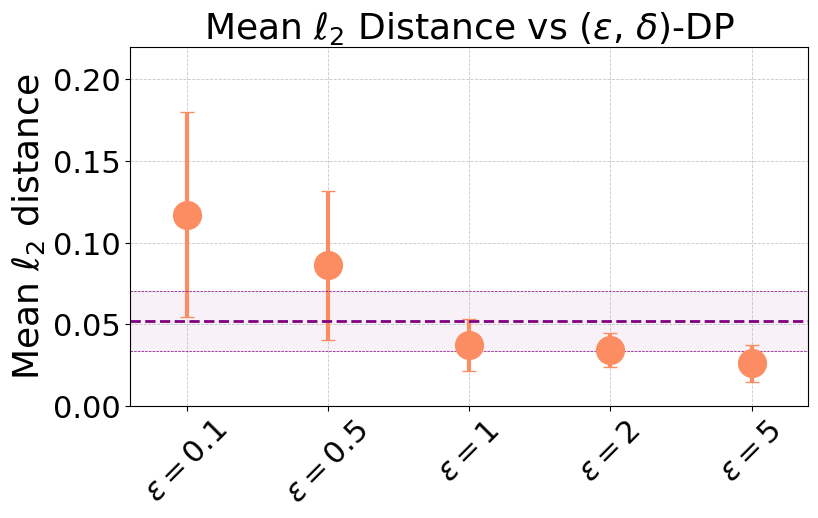

In [45]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(results_mean.keys()),
    results_mean=results_mean,
    results_std=result_std,
    # results_mean_surrogate_NO_DP=results_mean_surrogate_NO_DP,
    # results_std_surrogate_NO_DP=result_std_surrogate_NO_DP,
    y_label=rf"Mean $\ell_2$ distance",
    title=rf"Mean $\ell_2$ Distance vs ($\epsilon$, $\delta$)-DP",
    y_lim=(0, 0.22),
    x_ticks=[
        r"$\epsilon=0.1$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=0.5$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=1$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=2$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=5$",  # \delta = 4 \times 10^{-4}$)",
    ],
    file_name="./income_images/income_l2_distance_filled.png",
    jittering=True,
    horizontal_line= metrics_single_explainer["L2"],
    horizontal_line_std=metrics_single_explainer["L2_std"],
    markers_preference="same",
    colors_preference="same",
)

## Cosine 

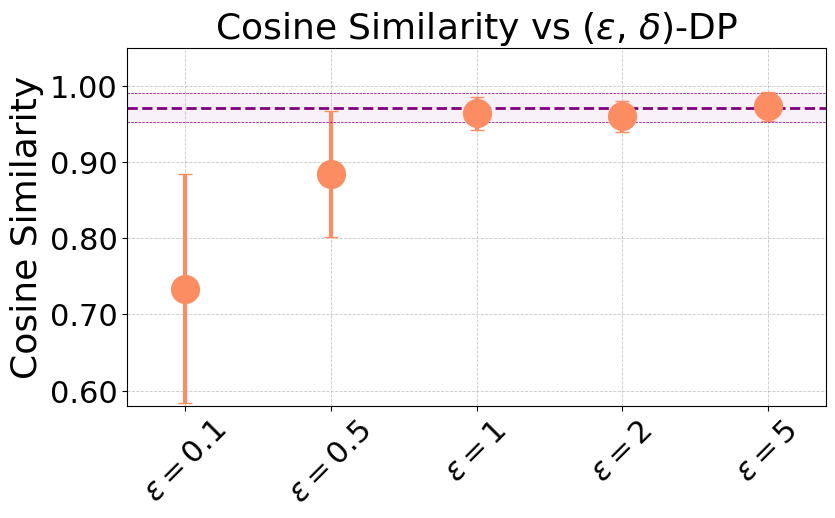

In [ ]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(cosine_mean.keys()),
    results_mean=cosine_mean_surrogate_NO_DP,
    results_std=cosine_std_surrogate_NO_DP,
    # results_mean_surrogate_NO_DP=cosine_mean_surrogate_NO_DP,
    # results_std_surrogate_NO_DP=cosine_std_surrogate_NO_DP,
    y_label="Cosine Similarity",
    title=rf"Cosine Similarity vs ($\epsilon$, $\delta$)-DP",
    y_lim=(0.58, 1.05),
    x_ticks=[
        r"$\epsilon=0.1$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=0.5$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=1$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=2$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=5$",  # \delta = 4 \times 10^{-4}$)",
    ],
    file_name="./income_images/income_cosine_filled.png",
    horizontal_line= metrics_single_explainer["cosine"],
    horizontal_line_std=metrics_single_explainer["cosine_std"],
    markers_preference="same",
    colors_preference="same",
)

## Spearman correlation

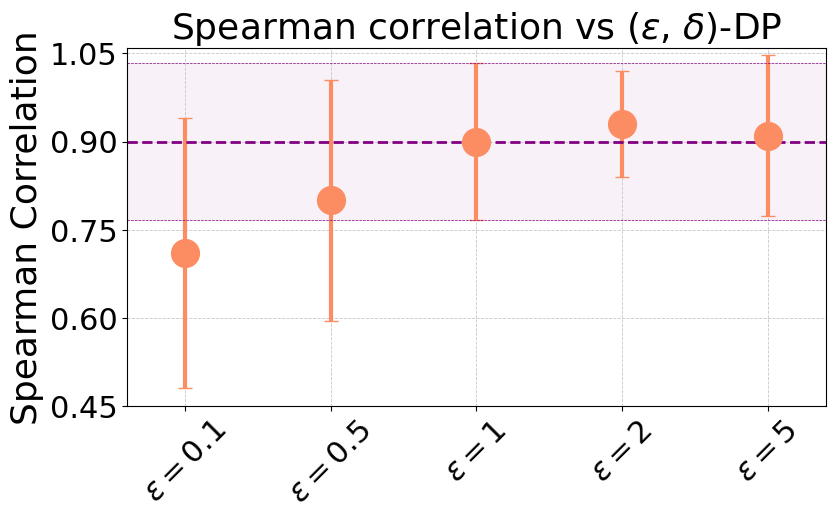

In [50]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(spearman_mean.keys()),
    results_mean=spearman_mean_surrogate_NO_DP,
    results_std=spearman_std_surrogate_NO_DP,
    # results_mean_surrogate_NO_DP=spearman_mean_surrogate_NO_DP,
    # results_std_surrogate_NO_DP=spearman_std_surrogate_NO_DP,
    y_label="Spearman Correlation",
    title="Spearman correlation vs ($\epsilon$, $\delta$)-DP",
    y_lim=(0.45, 1.06),
    x_ticks=[
        r"$\epsilon=0.1$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=0.5$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=1$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=2$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=5$",  # \delta = 4 \times 10^{-4}$)",
    ],
    file_name="./income_images/income_spearman_filled.png",
    horizontal_line= metrics_single_explainer["spearman"],
    horizontal_line_std=metrics_single_explainer["spearman_std"],
    markers_preference="same",
    colors_preference="same",
)

## Kendall correlation

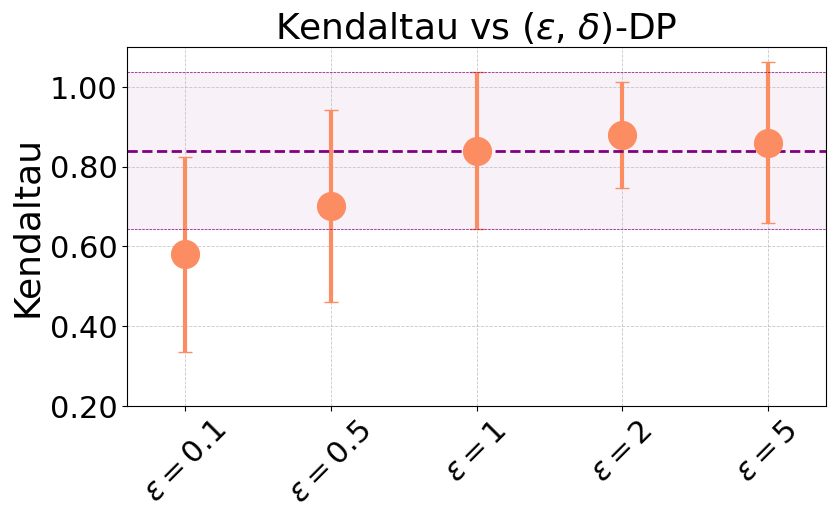

In [53]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(kendaltau_mean.keys()),
    results_mean=kendaltau_mean_surrogate_NO_DP,
    results_std=kendaltau_std_surrogate_NO_DP,
    # results_mean_surrogate_NO_DP=kendaltau_mean_surrogate_NO_DP,
    # results_std_surrogate_NO_DP=kendaltau_std_surrogate_NO_DP,
    y_label="Kendaltau",
    title="Kendaltau vs ($\epsilon$, $\delta$)-DP",
    y_lim=(0.2, 1.1),
    x_ticks=[
        r"$\epsilon=0.1$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=0.5$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=1$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=2$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=5$",  # \delta = 4 \times 10^{-4}$)",
    ],
    file_name="./income_images/income_kendal_filled.png",
    horizontal_line= metrics_single_explainer["kendall"],
    horizontal_line_std=metrics_single_explainer["kendall_std"],
    markers_preference="same",
    colors_preference="same",
)

## Feature Agreement

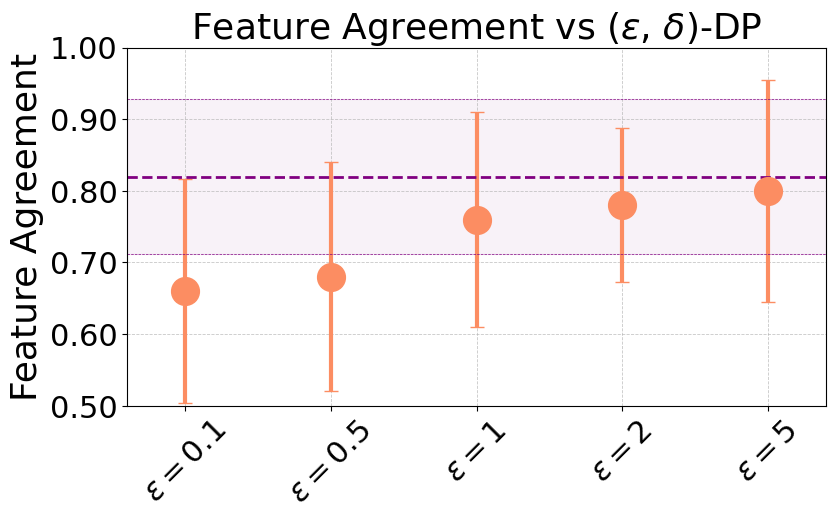

In [57]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(feature_agreement_mean.keys()),
    results_mean=feature_agreement_mean_surrogate_NO_DP,
    results_std=feature_agreement_std_surrogate_NO_DP,
    # results_mean_surrogate_NO_DP=feature_agreement_mean_surrogate_NO_DP,
    # results_std_surrogate_NO_DP=feature_agreement_std_surrogate_NO_DP,
    y_label="Feature Agreement",
    title="Feature Agreement vs ($\epsilon$, $\delta$)-DP",
    y_lim=(0.5, 1.),
    x_ticks=[
        r"$\epsilon=0.1$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=0.5$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=1$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=2$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=5$",  # \delta = 4 \times 10^{-4}$)",
    ],
    file_name="./income_images/income_feat_agreement_filled.png",
    horizontal_line= metrics_single_explainer["feature_agreement"],
    horizontal_line_std=metrics_single_explainer["feature_agreement_std"],
    markers_preference="same",
    colors_preference="same",
)

## Rank Agreement

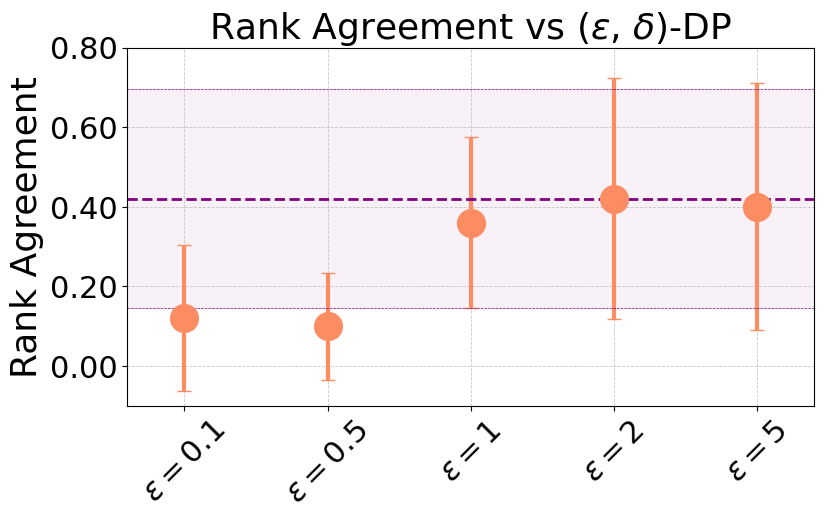

In [59]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(rank_agreement_mean.keys()),
    results_mean=rank_agreement_mean_surrogate_NO_DP,
    results_std=rank_agreement_std_surrogate_NO_DP,
    # results_mean_surrogate_NO_DP=rank_agreement_mean_surrogate_NO_DP,
    # results_std_surrogate_NO_DP=rank_agreement_std_surrogate_NO_DP,
    y_label="Rank Agreement",
    title="Rank Agreement vs ($\epsilon$, $\delta$)-DP",
    y_lim=(-0.1, 0.8),
    x_ticks=[
        r"$\epsilon=0.1$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=0.5$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=1$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=2$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=5$",  # \delta = 4 \times 10^{-4}$)",
    ],
    file_name="./income_images/income_rank_agreement_filled.png",
    horizontal_line= metrics_single_explainer["rank_agreement"],
    horizontal_line_std=metrics_single_explainer["rank_agreement_std"],
    markers_preference="same",
    colors_preference="same",
)

## Sign Agreement

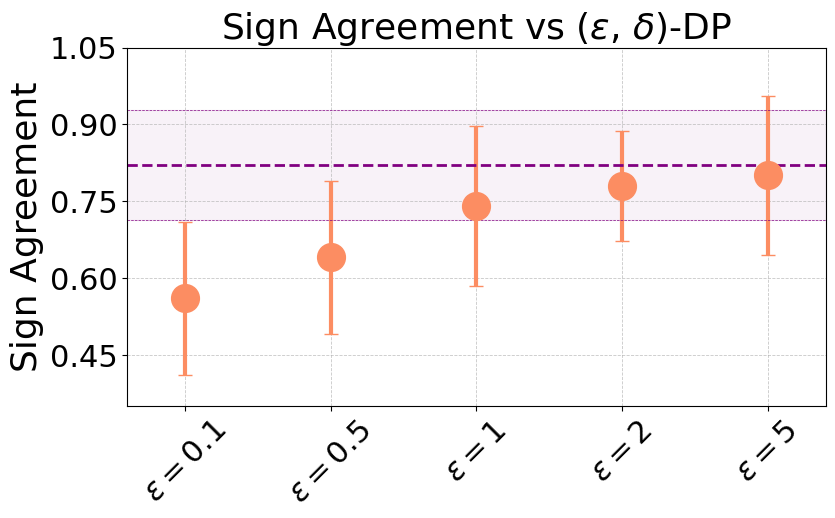

In [60]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(sign_agreement_mean.keys()),
    results_mean=sign_agreement_mean_surrogate_NO_DP,
    results_std=sign_agreement_std_surrogate_NO_DP,
    # results_mean_surrogate_NO_DP=sign_agreement_mean_surrogate_NO_DP,
    # results_std_surrogate_NO_DP=sign_agreement_std_surrogate_NO_DP,
    y_label="Sign Agreement",
    title="Sign Agreement vs ($\epsilon$, $\delta$)-DP",
    y_lim=(0.35, 1.05),
    x_ticks=[
        r"$\epsilon=0.1$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=0.5$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=1$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=2$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=5$",  # \delta = 4 \times 10^{-4}$)",
    ],
    file_name="./income_images/income_sign_agreement_filled.png",
    horizontal_line= metrics_single_explainer["sign_agreement"],
    horizontal_line_std=metrics_single_explainer["sign_agreement_std"],
    markers_preference="same",
    colors_preference="same",
)

## Sign Rank Agreement

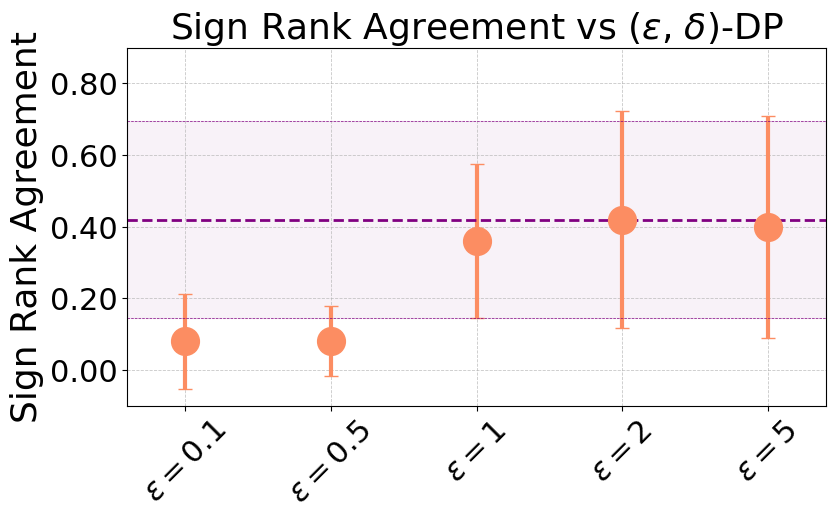

In [61]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(signed_rank_agreement_mean.keys()),
    results_mean=signed_rank_agreement_mean_surrogate_NO_DP,
    results_std=signed_rank_agreement_std_surrogate_NO_DP,
    # results_mean_surrogate_NO_DP=signed_rank_agreement_mean_surrogate_NO_DP,
    # results_std_surrogate_NO_DP=signed_rank_agreement_std_surrogate_NO_DP,
    y_label="Sign Rank Agreement",
    title="Sign Rank Agreement vs ($\epsilon$, $\delta$)-DP",
    y_lim=(-0.1, 0.9),
    x_ticks=[
        r"$\epsilon=0.1$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=0.5$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=1$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=2$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=5$",  # \delta = 4 \times 10^{-4}$)",
    ],
    file_name="./income_images/income_sign_rank_agreement_filled.png",
    horizontal_line= metrics_single_explainer["signed_rank_agreement"],
    horizontal_line_std=metrics_single_explainer["signed_rank_agreement_std"],
    markers_preference="same",
    colors_preference="same",
)

## Pairwise Rank 

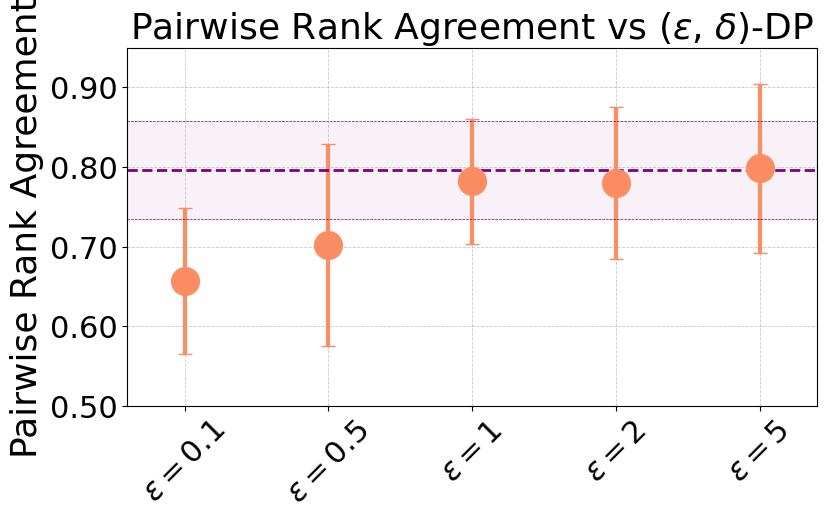

In [64]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(pairwise_rank_agreement_t_mean.keys()),
    results_mean=pairwise_rank_agreement_t_mean_surrogate_NO_DP,
    results_std=pairwise_rank_agreement_t_std_surrogate_NO_DP,
    # results_mean_surrogate_NO_DP=pairwise_rank_a°reement_t_std_surrogate_NO_DP,
    y_label="Pairwise Rank Agreement",
    title="Pairwise Rank Agreement vs ($\epsilon$, $\delta$)-DP",
    y_lim=(0.5, 0.95),
    x_ticks=[
        r"$\epsilon=0.1$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=0.5$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=1$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=2$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=5$",  # \delta = 4 \times 10^{-4}$)",
    ],
    file_name="./income_images/income_pairwise_rank_agreement_filled.png",
    horizontal_line= metrics_single_explainer["pairwise_rank_agreement"],
    horizontal_line_std=metrics_single_explainer["pairwise_rank_agreement_std"],
    markers_preference="same",
    colors_preference="same",
)

## Rank Correlation

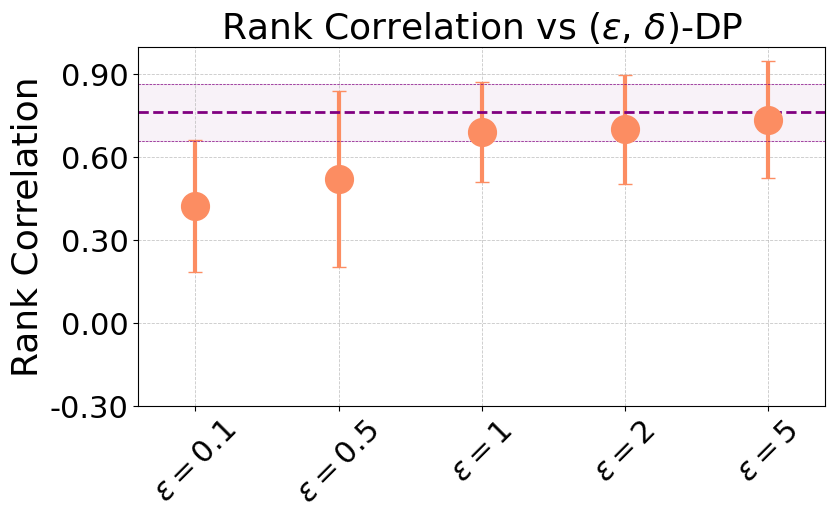

In [65]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(rank_corr_mean.keys()),
    results_mean=rank_corr_mean_surrogate_NO_DP,
    results_std=rank_corr_std_surrogate_NO_DP,
    # results_mean_surrogate_NO_DP=rank_corr_mean_surrogate_NO_DP,
    # results_std_surrogate_NO_DP=rank_corr_std_surrogate_NO_DP,
    y_label="Rank Correlation",
    title="Rank Correlation vs ($\epsilon$, $\delta$)-DP",
    y_lim=(-0.3, 1),
    x_ticks=[
        r"$\epsilon=0.1$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=0.5$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=1$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=2$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=5$",  # \delta = 4 \times 10^{-4}$)",
    ],
    file_name="./income_images/income_rank_correlation_filled.png",
    horizontal_line= metrics_single_explainer["rank_corr"],
    horizontal_line_std=metrics_single_explainer["rank_corr_std"],
    markers_preference="same",
    colors_preference="same",
)

# Faithfulness

In [67]:
faithfulness_mean = {}
faithfulness_std = {}
faithfulness_mean_no_DP = {}
faithfulness_std_no_DP = {}

faithfulness_single_value_mean = np.mean(np.array(loaded_data_surrogate_NO_DP["faithfulness_NO_DP"]) - np.array(loaded_data_surrogate_DP["faithfulness_NO_DP"]))
faithfulness_single_value_std = np.std(np.array(loaded_data_surrogate_NO_DP["faithfulness_NO_DP"]) - np.array(loaded_data_surrogate_DP["faithfulness_NO_DP"]))

for epsilon in explainer_privacy_levels[1:]:
    value = str(epsilon).split("_")[1]
    faithfulness_mean[f"Epsilon {value}"] = np.mean(np.array(loaded_data_surrogate_DP["faithfulness_NO_DP"]) - np.array(loaded_data_surrogate_DP[f"faithfulness_{epsilon}"]))
    faithfulness_std[f"Epsilon {value}"] = np.std(np.array(loaded_data_surrogate_DP["faithfulness_NO_DP"]) - np.array(loaded_data_surrogate_DP[f"faithfulness_{epsilon}"]))

    faithfulness_mean_no_DP[f"Epsilon {value}"] = np.mean(np.array(loaded_data_surrogate_NO_DP["faithfulness_NO_DP"]) - np.array(loaded_data_surrogate_NO_DP[f"faithfulness_{epsilon}"]))
    faithfulness_std_no_DP[f"Epsilon {value}"] = np.std(np.array(loaded_data_surrogate_NO_DP["faithfulness_NO_DP"]) - np.array(loaded_data_surrogate_NO_DP[f"faithfulness_{epsilon}"]))


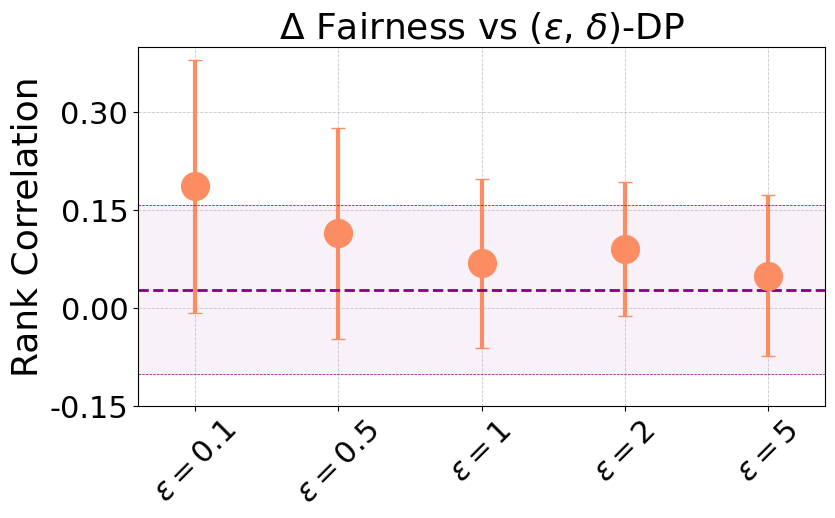

In [70]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(rank_corr_mean.keys()),
    results_mean=faithfulness_mean_no_DP,
    results_std=faithfulness_std_no_DP,
    # results_mean_surrogate_NO_DP=faithfulness_mean_no_DP,
    # results_std_surrogate_NO_DP=faithfulness_std_no_DP,
    y_label="Rank Correlation",
    title=f"$\Delta$ Fairness vs ($\epsilon$, $\delta$)-DP",
    y_lim=(-0.15, 0.4),
    x_ticks=[
        r"$\epsilon=0.1$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=0.5$",  # , \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=1$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=2$",  # \delta = 4 \times 10^{-4}$)",
        r"$\epsilon=5$",  # \delta = 4 \times 10^{-4}$)",
    ],
    file_name="./income_images/income_faithfulness_filled.png",
    horizontal_line= faithfulness_single_value_mean,
    horizontal_line_std=faithfulness_single_value_std,
    markers_preference="same",
    colors_preference="same",
)

# Table

In [126]:
import pandas as pd

In [74]:
import pandas as pd

# Define the epsilon values
epsilon_values = ["01", "05", "1", "2", "5"]
epsilon_values_list = ["0.1", "0.5", "1", "2", "5"]

metrics_dict = {
    "L2 Distance": [f"{results_mean[f'Epsilon {eps}']:.2f}"+r"$\pm$"+f"{result_std[f'Epsilon {eps}']:.2f}" for eps in epsilon_values] + [f"{results_mean_surrogate_NO_DP[f'Epsilon {eps}']:.2f}"+r"$\pm$"+f"{result_std_surrogate_NO_DP[f'Epsilon {eps}']:.2f}" for eps in epsilon_values] + [f"{metrics_single_explainer['L2']:.2f}"+r"$\pm$"+f"{metrics_single_explainer['L2_std']:.2f}"],
    "Cosine Similarity": [f"{cosine_mean[f'Epsilon {eps}']:.2f}"+r"$\pm$"+f"{cosine_std[f'Epsilon {eps}']:.2f}" for eps in epsilon_values] + [f"{cosine_mean_surrogate_NO_DP[f'Epsilon {eps}']:.2f}"+r"$\pm$"+f"{cosine_std_surrogate_NO_DP[f'Epsilon {eps}']:.2f}" for eps in epsilon_values] + [f"{metrics_single_explainer['cosine']:.2f}"+r"$\pm$"+f"{metrics_single_explainer['cosine_std']:.2f}"],
    "Feature Agreement": [f"{feature_agreement_mean[f'Epsilon {eps}']:.2f}"+r"$\pm$"+f"{feature_agreement_std[f'Epsilon {eps}']:.2f}" for eps in epsilon_values] + [f"{feature_agreement_mean_surrogate_NO_DP[f'Epsilon {eps}']:.2f}"+r"$\pm$"+f"{feature_agreement_std_surrogate_NO_DP[f'Epsilon {eps}']:.2f}" for eps in epsilon_values] + [f"{metrics_single_explainer['feature_agreement']:.2f}"+r"$\pm$"+f"{metrics_single_explainer['feature_agreement_std']:.2f}"],
    "Sign Agreement": [f"{sign_agreement_mean[f'Epsilon {eps}']:.2f}"+r"$\pm$"+f"{sign_agreement_std[f'Epsilon {eps}']:.2f}" for eps in epsilon_values] + [f"{sign_agreement_mean_surrogate_NO_DP[f'Epsilon {eps}']:.2f}"+r"$\pm$"+f"{sign_agreement_std_surrogate_NO_DP[f'Epsilon {eps}']:.2f}" for eps in epsilon_values] + [f"{metrics_single_explainer['sign_agreement']:.2f}"+r"$\pm$"+f"{metrics_single_explainer['sign_agreement_std']:.2f}"],
    "Rank Correlation": [f"{rank_corr_mean[f'Epsilon {eps}']:.2f}"+r"$\pm$"+f"{rank_corr_std[f'Epsilon {eps}']:.2f}" for eps in epsilon_values] + [f"{rank_corr_mean_surrogate_NO_DP[f'Epsilon {eps}']:.2f}"+r"$\pm$"+f"{rank_corr_std_surrogate_NO_DP[f'Epsilon {eps}']:.2f}" for eps in epsilon_values] + [f"{metrics_single_explainer['rank_corr']:.2f}"+r"$\pm$"+f"{metrics_single_explainer['rank_corr_std']:.2f}"],
    "Faithfulness": [f"{faithfulness_mean[f'Epsilon {eps}']:.2f}"+r"$\pm$"+f"{faithfulness_std[f'Epsilon {eps}']:.2f}" for eps in epsilon_values] + [f"{faithfulness_mean_no_DP[f'Epsilon {eps}']:.2f}"+r"$\pm$"+f"{faithfulness_std_no_DP[f'Epsilon {eps}']:.2f}" for eps in epsilon_values] + [f"{faithfulness_single_value_mean:.2f}"+r"$\pm$"+f"{faithfulness_single_value_std:.2f}"],
}

# Define the index for the DataFrame
index = [rf"($\epsilon={eps}, \delta = 4 \times 10^{{-4}}$)" for eps in epsilon_values_list] + [rf"($\epsilon={eps}, \delta = 4 \times 10^{{-4}}$) (NO_DP)" for eps in epsilon_values_list] + ["Single Value"]

metrics_df = pd.DataFrame(metrics_dict, index=index)

print(metrics_df.to_latex())


\begin{tabular}{lllllll}
\toprule
 & L2 Distance & Cosine Similarity & Feature Agreement & Sign Agreement & Rank Correlation & Faithfulness \\
\midrule
($\epsilon=0.1, \delta = 4 \times 10^{-4}$) & 0.12$\pm$0.06 & 0.76$\pm$0.13 & 0.62$\pm$0.11 & 0.56$\pm$0.17 & 0.41$\pm$0.22 & 0.16$\pm$0.17 \\
($\epsilon=0.5, \delta = 4 \times 10^{-4}$) & 0.09$\pm$0.05 & 0.91$\pm$0.06 & 0.64$\pm$0.17 & 0.64$\pm$0.17 & 0.54$\pm$0.34 & 0.09$\pm$0.12 \\
($\epsilon=1, \delta = 4 \times 10^{-4}$) & 0.04$\pm$0.02 & 0.99$\pm$0.01 & 0.76$\pm$0.15 & 0.76$\pm$0.15 & 0.74$\pm$0.14 & 0.04$\pm$0.06 \\
($\epsilon=2, \delta = 4 \times 10^{-4}$) & 0.03$\pm$0.01 & 0.97$\pm$0.02 & 0.88$\pm$0.13 & 0.88$\pm$0.13 & 0.83$\pm$0.09 & 0.06$\pm$0.07 \\
($\epsilon=5, \delta = 4 \times 10^{-4}$) & 0.03$\pm$0.01 & 0.99$\pm$0.01 & 0.86$\pm$0.09 & 0.86$\pm$0.09 & 0.86$\pm$0.11 & 0.02$\pm$0.05 \\
($\epsilon=0.1, \delta = 4 \times 10^{-4}$) (NO_DP) & 0.14$\pm$0.07 & 0.73$\pm$0.15 & 0.66$\pm$0.16 & 0.56$\pm$0.15 & 0.42$\pm$0.24 & 0.19$